In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 
pd.options.display.float_format = '{:,.2f}'.format

start = time.perf_counter()

In [17]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv') 
# df = pd.read_csv('jammedaxis27109-infinite-matchhistory.csv')
# df.info()
# df.describe().transpose()

In [18]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] > '2024-02-04']

df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)

dfr = df[df['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
# dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
# dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0, 'Draw': 0.5})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                           (dfr['Outcome'].cumsum() + 
                            dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('dfNS.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               196 non-null    int64         
 1   Date                196 non-null    datetime64[ns]
 2   SeasonNumber        196 non-null    int64         
 3   SeasonVersion       196 non-null    int64         
 4   Map                 196 non-null    object        
 5   Category            196 non-null    object        
 6   Rank                196 non-null    int64         
 7   Outcome             196 non-null    float64       
 8   Accuracy            196 non-null    float64       
 9   DamageDone          196 non-null    int64         
 10  DamageTaken         196 non-null    int64         
 11  ShotsFired          196 non-null    int64         
 12  ShotsLanded         196 non-null    int64         
 13  ShotsMissed         196 non-null    int64         

In [19]:
dfr.tail(2)

,index,Date,SeasonNumber,SeasonVersion,Map,Category,Rank,Outcome,Accuracy,DamageDone,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
194,905,2024-03-18 02:04:59,6,1,Aquarius,Slayer,8,0.00,55.73,3373,...,1.11,1.17,52.97,27.47,9.55,53.14,7.29,2.55,1073,0.59
195,906,2024-03-18 02:13:56,6,1,Forbidden,CTF 3 Captures,7,0.00,48.47,3581,...,1.11,1.17,52.96,27.58,9.52,53.08,7.27,2.54,1063,0.59


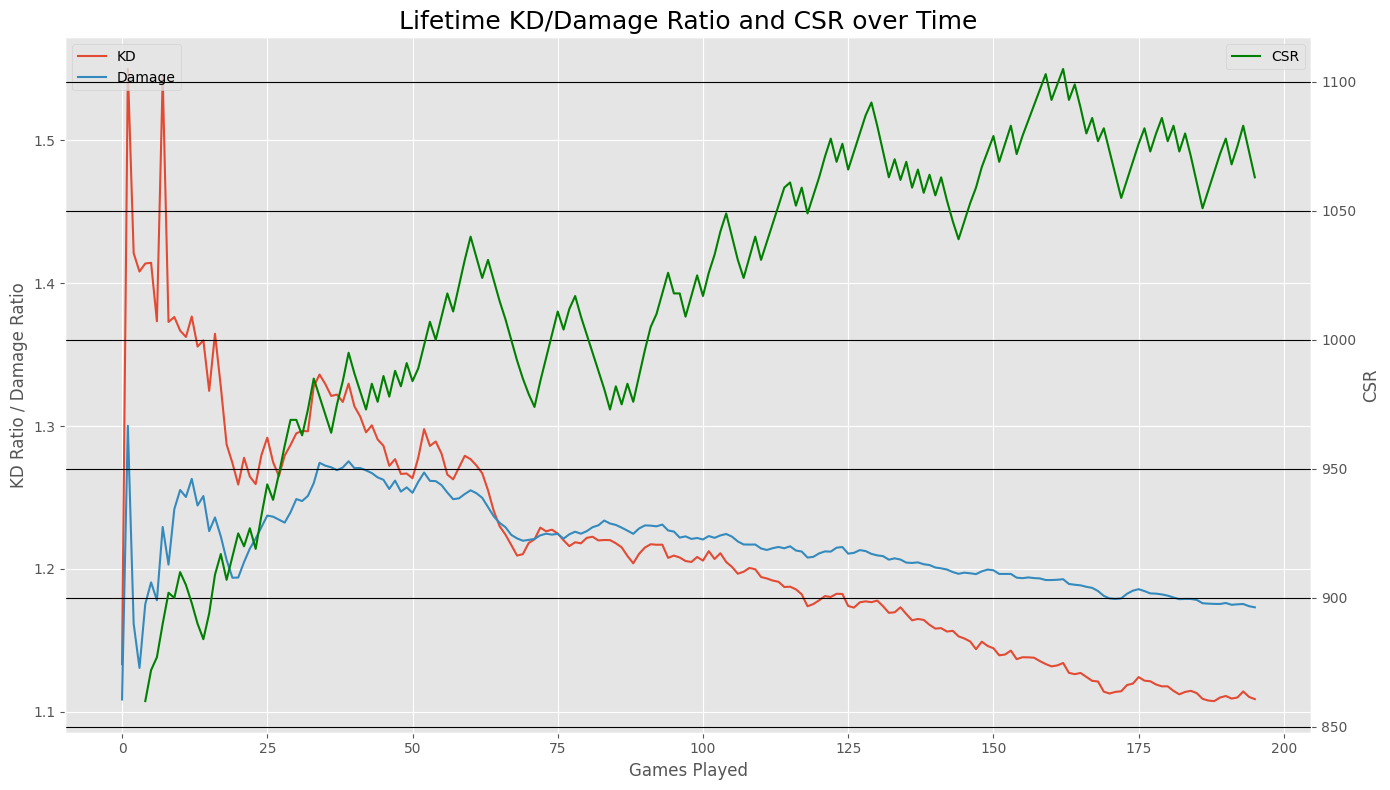

In [20]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][4:], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True, color='black')
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

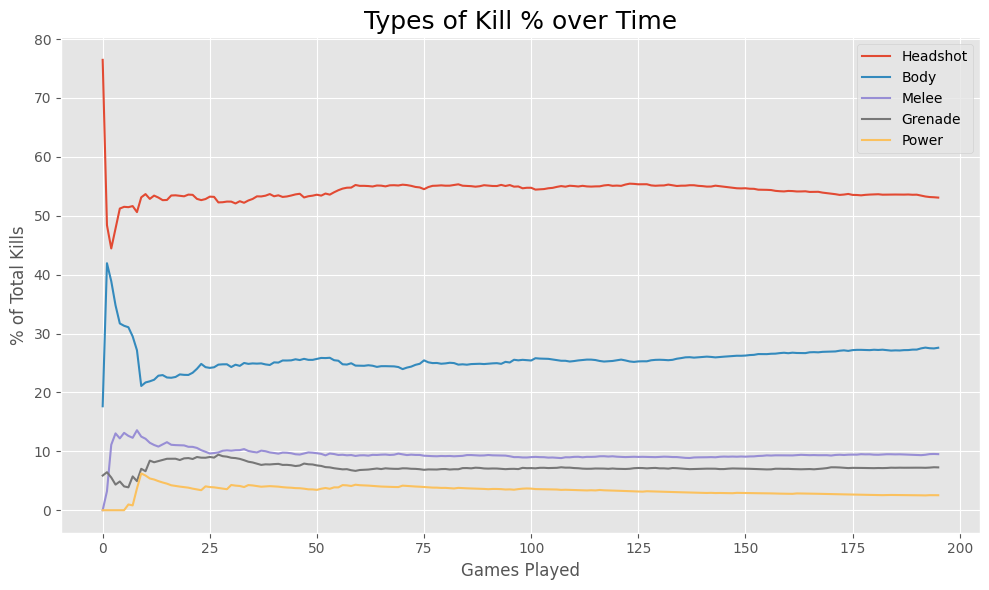

In [21]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeHSPct'], label='Headshot')
plt.plot(dfr['LifetimeBodyPct'], label='Body')
plt.plot(dfr['LifetimeMeleePct'], label='Melee')
plt.plot(dfr['LifetimeGrenadePct'], label='Grenade')
plt.plot(dfr['LifetimePowerPct'], label='Power')
plt.title('Types of Kill % over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('% of Total Kills')
plt.legend(loc='best')
plt.grid(True, axis='y')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

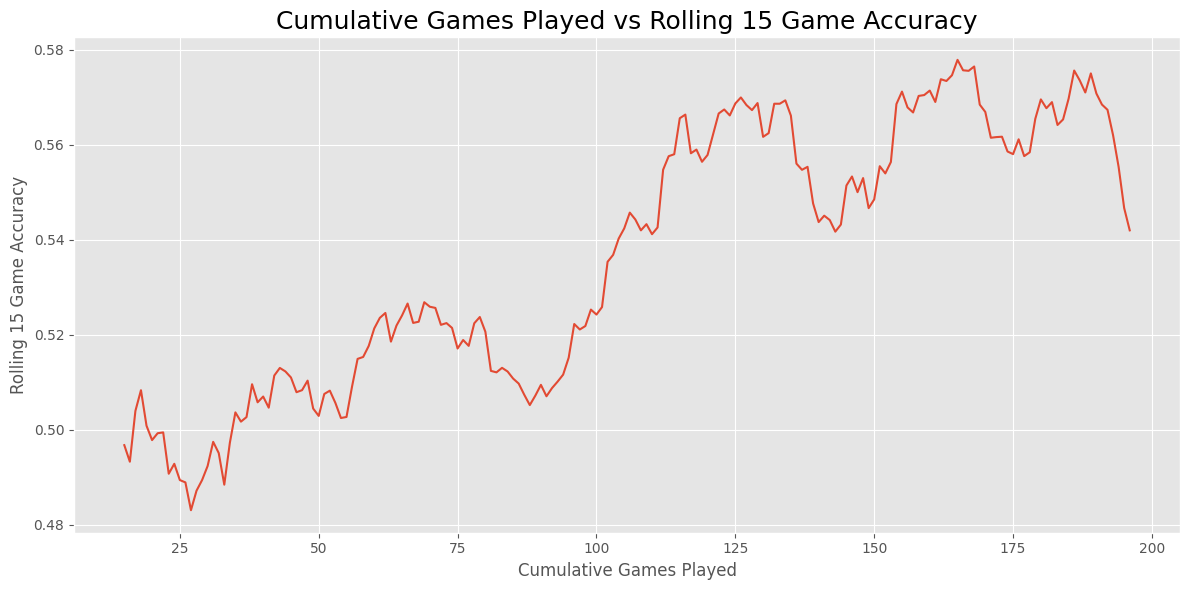

In [22]:
mod = 15

# Line graph of cumulative games played and rolling 50 game accuracy
dfr['CumulativeGames'] = np.arange(1, len(dfr) + 1)
dfr['RollingAccuracy'] = dfr['ShotsLanded'].rolling(window=mod).sum() / dfr['ShotsFired'].rolling(window=mod).sum()

plt.figure(figsize=(12, 6))
plt.plot(dfr['CumulativeGames'], dfr['RollingAccuracy'])
plt.title(f'Cumulative Games Played vs Rolling {mod} Game Accuracy', fontsize=18)
plt.xlabel('Cumulative Games Played')
plt.ylabel(f'Rolling {mod} Game Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


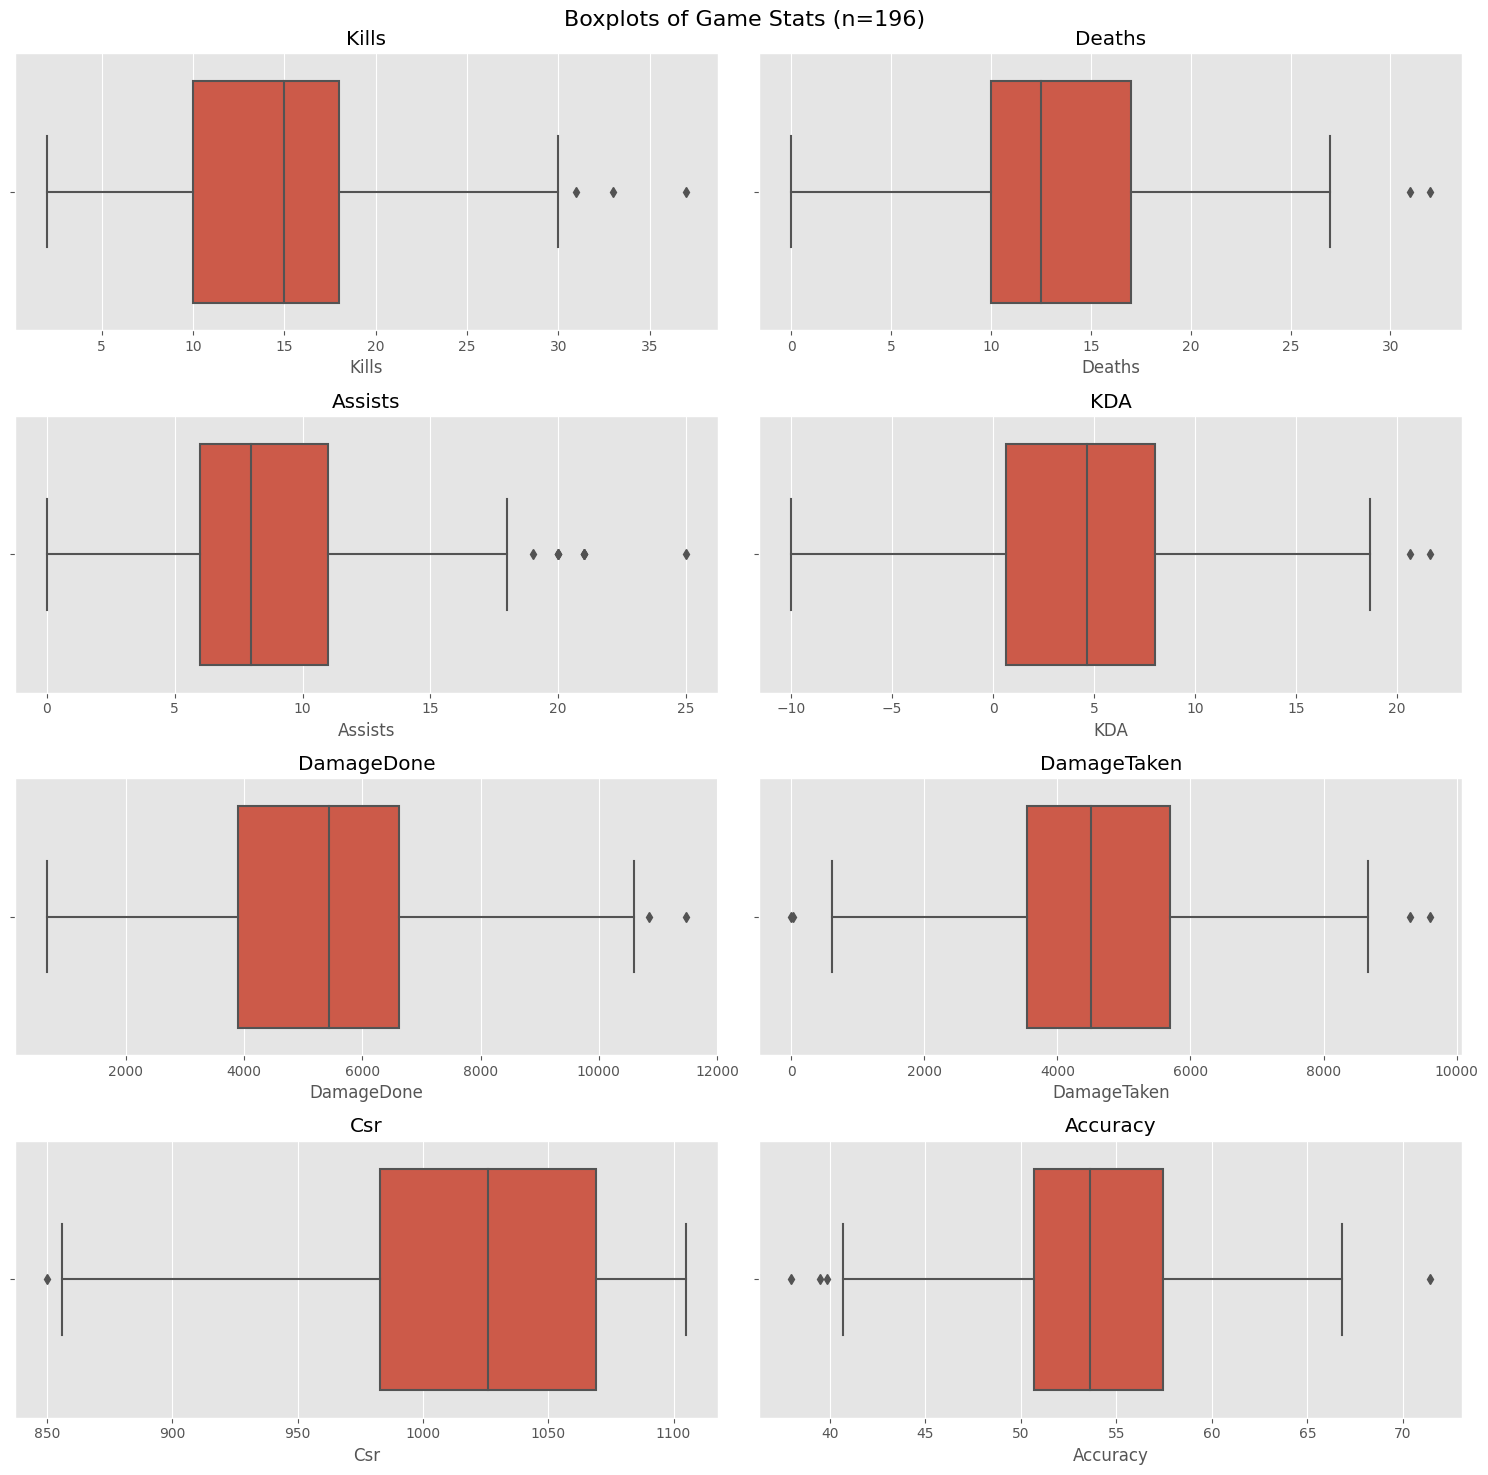

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle(f'Boxplots of Game Stats (n={len(dfr)})', fontsize=16)
plt.tight_layout()
# plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [24]:
dfrcc = dfr.groupby(['Category','Map']).agg(
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Category', 'Map'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Kills/10Min', ascending=False),2)
dfrcc

Wins  Losses  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                           
CTF              Aquarius      9       5    251     190      142       90313   
Strongholds      Solitude      7       4    180     139      105       59407   
King of the Hill Recharge      6      11    278     246      199      104454   
Strongholds      Live Fire     4       4    137     109       69       47340   
Oddball          Streets      10       1    190     165      115       67749   
                 Recharge      8       2    167     133      121       60065   
CTF 3 Captures   Empyrean      9       9    310     286      140      112441   
King of the Hill Solitude      7       3    153     139      114       59173   
CTF 3 Captures   Argyle        9      10    301     260      148      108860   
Oddball          Live Fire     5       4    154     171       96       58118   
CTF 3 Captures   Forbidden     9       7    180     149       97       68227   
Slayer           Live Fire     7       2     94      84       62       34617   
King of the Hill Live Fire     4       0     56      60       47       23210   
Slayer           Solitude      9       2    113     103       93       44364   
Strongholds      Recharge      4       3     94      88       55       34995   
Slayer           Recharge      2       2     39      36       23       13979   
                 Aquarius      2       5     60      76       51       28480   
                 Streets       4       6     84      96       68       37923   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
CTF              Aquarius         69452     0.64         155.93     54.86   
Strongholds      Solitude         50135     0.64         114.68     54.02   
King of the Hill Recharge         87555     0.35         190.22     52.20   
Strongholds      Live Fire        38886     0.50          94.02     57.17   
Oddball          Streets          55462     0.91         133.38     54.72   
                 Recharge         46575     0.80         117.78     53.15   
CTF 3 Captures   Empyrean        101430     0.50         228.88     52.28   
King of the Hill Solitude         47825     0.70         113.20     53.74   
CTF 3 Captures   Argyle           90765     0.47         223.33     53.23   
Oddball          Live Fire        54404     0.56         121.05     54.68   
CTF 3 Captures   Forbidden        54633     0.56         144.60     52.12   
Slayer           Live Fire        30791     0.78          76.15     54.76   
King of the Hill Live Fire        20682     1.00          47.00     54.73   
Slayer           Solitude         38364     0.82          95.73     51.39   
Strongholds      Recharge         33425     0.57          80.20     50.83   
Slayer           Recharge         13048     0.50          34.33     47.53   
                 Aquarius         27627     0.29          56.27     53.77   
                 Streets          34962     0.40          84.70     53.49   

                             KD  DamageRatio  Dmg/Life  Dmg/KA  ExDmg/Life  \
Category         Map                                                         
CTF              Aquarius  1.32         1.30    475.33  229.80      109.79   
Strongholds      Solitude  1.29         1.18    427.39  208.45       66.71   
King of the Hill Recharge  1.13         1.19    424.61  218.98       68.70   
Strongholds      Live Fire 1.26         1.22    434.31  229.81       77.56   
Oddball          Streets   1.15         1.22    410.60  222.13       74.47   
                 Recharge  1.26         1.29    451.62  208.56      101.43   
CTF 3 Captures   Empyrean  1.08         1.11    393.15  249.87       38.50   
King of the Hill Solitude  1.10         1.24    425.71  221.62       81.64   
CTF 3 Captures   Argyle    1.16         1.20    418.69  242.45       69.60   
Oddball          Live Fire 0

In [25]:
dfrcc = dfr.groupby('Map').agg(
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,Dmg/KA,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,,,,,,
Solitude,23,9,446,381,312,3907,7347,162944,136324,0.72,323.62,1.17,1.20,427.67,214.97,69.87,0.82
Live Fire,20,10,441,424,274,3616,6529,163285,144763,0.67,338.22,1.04,1.13,385.11,228.37,43.68,0.65
Streets,14,7,274,261,183,2414,4449,105672,90424,0.67,218.08,1.05,1.17,404.87,231.23,58.42,0.70
Forbidden,9,7,180,149,97,1551,2976,68227,54633,0.56,144.60,1.21,1.25,457.90,246.31,91.23,0.65
Recharge,20,18,578,503,398,4971,9580,213493,180603,0.53,422.53,1.15,1.18,424.44,218.74,65.39,0.79
Aquarius,11,10,311,266,193,2771,5077,118793,97079,0.52,212.20,1.17,1.22,446.59,235.70,81.63,0.73
Empyrean,9,9,310,286,140,2642,5054,112441,101430,0.50,228.88,1.08,1.11,393.15,249.87,38.50,0.49
Argyle,9,10,301,260,148,2479,4657,108860,90765,0.47,223.33,1.16,1.20,418.69,242.45,69.60,0.57


In [26]:
dfrcc = dfr.groupby('Category').agg(
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
    
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,Dmg/KA,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,,,,,,
Oddball,23,7,511,469,332,4151,7662,185932,156441,0.77,372.22,1.09,1.19,396.44,220.56,62.88,0.71
CTF,9,5,251,190,142,2065,3764,90313,69452,0.64,155.93,1.32,1.30,475.33,229.80,109.79,0.75
Slayer,24,17,390,395,297,3805,7226,159363,144792,0.59,347.18,0.99,1.10,403.45,231.97,36.89,0.75
Strongholds,15,11,411,336,229,3300,6104,141742,122446,0.58,288.90,1.22,1.16,421.85,221.47,57.43,0.68
King of the Hill,17,14,487,445,360,4358,8226,186837,156062,0.55,350.42,1.09,1.20,419.86,220.59,69.16,0.81
CTF 3 Captures,27,26,791,695,385,6672,12687,289528,246828,0.51,596.82,1.14,1.17,416.59,246.20,61.44,0.55


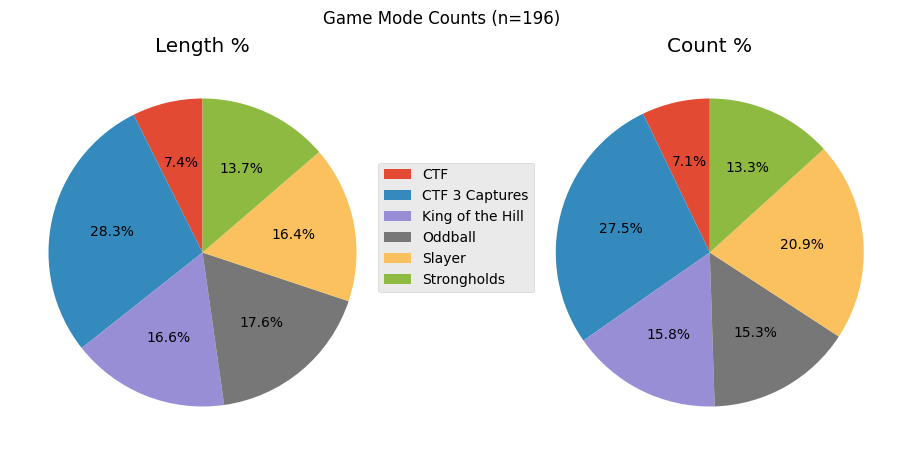

In [27]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()


fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
# Update the title of the plot to include the total game count
fig.suptitle(f'Game Mode Counts (n={totalcount})')

ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")

plt.show()

In [28]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)


print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Totals
Total Games: 196
Total Kills: 2841
Total Deaths: 2530
Total Assists: 1745
----------------------------
Overall
Overall KD: 1.15
Average Kills: 13.33
Average Deaths: 11.58
Average Assists: 8.26
Average Accuracy: 53.32
Average Damage Done: 5376
Average Damage Taken: 4572
Damage Ratio: 1.18
Win-Loss: 115-80
----------------------------
Wins
Overall KD: 1.33
Average Kills: 13.98
Average Deaths: 10.54
Average Assists: 8.86
Average Accuracy: 54.27
Average Damage Done: 5263
Average Damage Taken: 4209
Damage Ratio: 1.25
Wins: 115
----------------------------
Losses
Overall KD: 0.95
Average Kills: 12.37
Average Deaths: 13.06
Average Assists: 7.41
Average Accuracy: 52.2
Average Damage Done: 5509
Average Damage Taken: 5050
Damage Ratio: 1.09
Losses: 80


In [29]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 1.2978413329983596s
